From explore.ipynb we can find the images that we can augment by rotating, flipping or mirroring.
## TODO

Ideas:

- Balance data by augmentation (Create more new pictures for underrepresented signs)
- Assign different signs to different augmentation methods --> What is possible for which method?

Signs:

- 1) Speed Limit Zone beginning (30) --> Ordner: 00001
- 2) Speed Limit Zone end (30) --> Ordner: KEINE DATEN bis jetzt
- 3) Crosswalk --> Ordner: KEINE DATEN bis jetzt
- 4) Barred area --> Ordner: KEINE DATEN bis jetzt
- 5) Expressway beginning --> Ordner: KEINE DATEN bis jetzt
- 6) Expressway end --> Ordner: KEINE DATEN bis jetzt
- 7) Intersections STOP --> Ordner: 00014
- 8) Intersections "Vorfahrt gewähren" --> Ordner: 00013
- 9) Intersections "Vorfahrtsstraße"  --> Ordner: 00012
- 10) Turn Left  --> Ordner: 00034
- 11) Turn Right --> Do we need the counterparts here?  --> Ordner: 00033
- 12) No-passing zone beginning --> Ordner: 00009
- 13) No-passing zone end  --> Ordner: 00041
- 14) Sharp turn left small --> Ordner: KEINE DATEN bis jetzt
- 15) Sharp turn left large --> Ordner: KEINE DATEN bis jetzt
- 16) Sharp turn right small --> Do we need the counterparts here? --> Ordner: KEINE DATEN bis jetzt
- 17) Sharp turn right large --> Do we need the counterparts here? --> Ordner: KEINE DATEN bis jetzt
- 18) Steep hill uphill grade --> Ordner: KEINE DATEN bis jetzt
- 19) Steep hill downhill grade --> Ordner: KEINE DATEN bis jetzt

Methods to augment data + for which signs applicable:

-Flipping (horizontal/vertical)
    
    --> check possible invariances (e.g turn left signs) 
        and signs which can then be detected as other signs
        
    Horizontal:
    9)
    
    Vertical:
    5), 8), 9), 10) gets 11), 11) gets 10), 16) gets 17), 17) gets 16)
    
    Horizontal + Vertical:
    9)

-Rotating




## TODO

In [26]:
fippable_horizontally = [1, 5]

In [27]:
#Dict list for signs ('name': 'folderdirectory')
dict1 = {'Speed Limit Zone beginning (30)': '/00001', 'Speed Limit Zone end (30)': '-', 'Crosswalk': '-', 'Barred area': '-', 'Expressway beginning': '-', 'Expressway end': '-', 'Intersections STOP': '/00014', 'Intersections "Vorfahrt gewähren"': '/00013', 'Intersections "Vorfahrtsstraße"': '/00012', 'Turn Left': '/00034', 'Turn Right': '/00033', 'No-passing zone beginning': '/00009', 'No-passing zone end': '/00041', 'Sharp turn left small': '-', 'Sharp turn left large': '-', 'Sharp turn right small': '-', 'Sharp turn right large': '-', 'Steep hill uphill grade': '-', 'Steep hill downhill grade': '-'}

#Print all sign types + link to the folders
for el in dict1:
    print (el, "-->", dict1[el], )

Speed Limit Zone beginning (30) --> /00001
Speed Limit Zone end (30) --> -
Crosswalk --> -
Barred area --> -
Expressway beginning --> -
Expressway end --> -
Intersections STOP --> /00014
Intersections "Vorfahrt gewähren" --> /00013
Intersections "Vorfahrtsstraße" --> /00012
Turn Left --> /00034
Turn Right --> /00033
No-passing zone beginning --> /00009
No-passing zone end --> /00041
Sharp turn left small --> -
Sharp turn left large --> -
Sharp turn right small --> -
Sharp turn right large --> -
Steep hill uphill grade --> -
Steep hill downhill grade --> -


GTSRB dataset is in place, you're fine.
/Users/maximilianbomer/Machine_Learning_TUM_Phoenix/GTSRB/Final_Training/Images


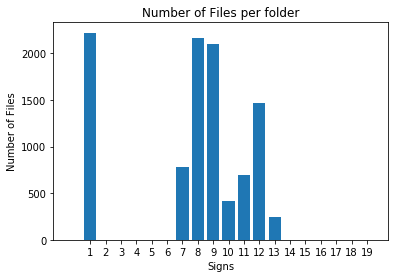

1: Speed Limit Zone beginning (30) --> 2221
2: Speed Limit Zone end (30) --> 0
3: Crosswalk --> 0
4: Barred area --> 0
5: Expressway beginning --> 0
6: Expressway end --> 0
7: Intersections STOP --> 781
8: Intersections "Vorfahrt gewähren" --> 2161
9: Intersections "Vorfahrtsstraße" --> 2101
10: Turn Left --> 421
11: Turn Right --> 690
12: No-passing zone beginning --> 1471
13: No-passing zone end --> 241
14: Sharp turn left small --> 0
15: Sharp turn left large --> 0
16: Sharp turn right small --> 0
17: Sharp turn right large --> 0
18: Steep hill uphill grade --> 0
19: Steep hill downhill grade --> 0


In [115]:
#Count images per cell
from gtsrb_loader.download_gtsrb import download_gtsrb
import os, os.path
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

path=download_gtsrb();

number_list = [0] #element 0 is 0
sign_list = ['a']

i = 0
for k in iter(dict1.keys()):
    if dict1[k] == '-':
        number_files = 0
    else:
        changed_path=path+dict1[k]
        list = os.listdir(changed_path) # dir is your directory path
        number_files = len(list)
    number_list.append(number_files)
    sign_list.append(k)

#Histogram
plt.bar(range(len(number_list)), number_list)
plt.xticks(range(1, len(number_list)))
plt.title("Number of Files per folder")
plt.xlabel("Signs")
plt.ylabel("Number of Files")
plt.show()

#Legende
for i in range(1, len(number_list)):
    print (str(i) + ": " + sign_list[i] + " --> " + str(number_list[i]))